In [1]:
!pip install pandasql

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=ac4f82fb12349afbd4c1139f26bc9ba1fdbedf6df6778ae5bfeec163e292ad42
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


In [2]:
from turtle import clear
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
import os
from pandasql import sqldf
#import modal
#import gradio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.svm import SVC
#from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
# Retrieve the "original" wine dataset
wine_df = pd.read_csv("https://raw.githubusercontent.com/ID2223KTH/id2223kth.github.io/master/assignments/lab1/wine.csv")


In [4]:
# Rename the columns in order to make there a consistent key, remove duplicates
wine_df = wine_df.rename(columns={"fixed acidity": "fixed_acid",
                        "volatile acidity": "volatile_acid",
                        "citric acid": "citric_acid",
                        "residual sugar": "residual_sugar",
                        "free sulfur dioxide": "free_sd",
                        "total sulfur dioxide": "total_sd"})

# Check the number and type of the values, as well as count of NaN values
#print(f'\n{wine_df.info()}')
#print(f'\n{wine_df.describe(include = "all")}')
wine_df.info()
wine_df.describe(include = "all")
wine_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   type            6497 non-null   object 
 1   fixed_acid      6487 non-null   float64
 2   volatile_acid   6489 non-null   float64
 3   citric_acid     6494 non-null   float64
 4   residual_sugar  6495 non-null   float64
 5   chlorides       6495 non-null   float64
 6   free_sd         6497 non-null   float64
 7   total_sd        6497 non-null   float64
 8   density         6497 non-null   float64
 9   pH              6488 non-null   float64
 10  sulphates       6493 non-null   float64
 11  alcohol         6497 non-null   float64
 12  quality         6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


type               0
fixed_acid        10
volatile_acid      8
citric_acid        3
residual_sugar     2
chlorides          2
free_sd            0
total_sd           0
density            0
pH                 9
sulphates          4
alcohol            0
quality            0
dtype: int64

In [5]:
################ DATATYPE #####################
# We have 6497 features, described by 13 values.
#
# Categorical features are: type (ordinal), quality (nominal)
# Numerical   features are: (int) quality; (float) fixed acid, residual_sugar,
#                           chlorides, free_sd, total_sd, density, pH,
#                           sulphates, alcohol, quality
#
# There are some missing values for: fixed_acid, volatile_acid, citric_acid, residual_sugar,
#                                    chlorides, pH, sulphates

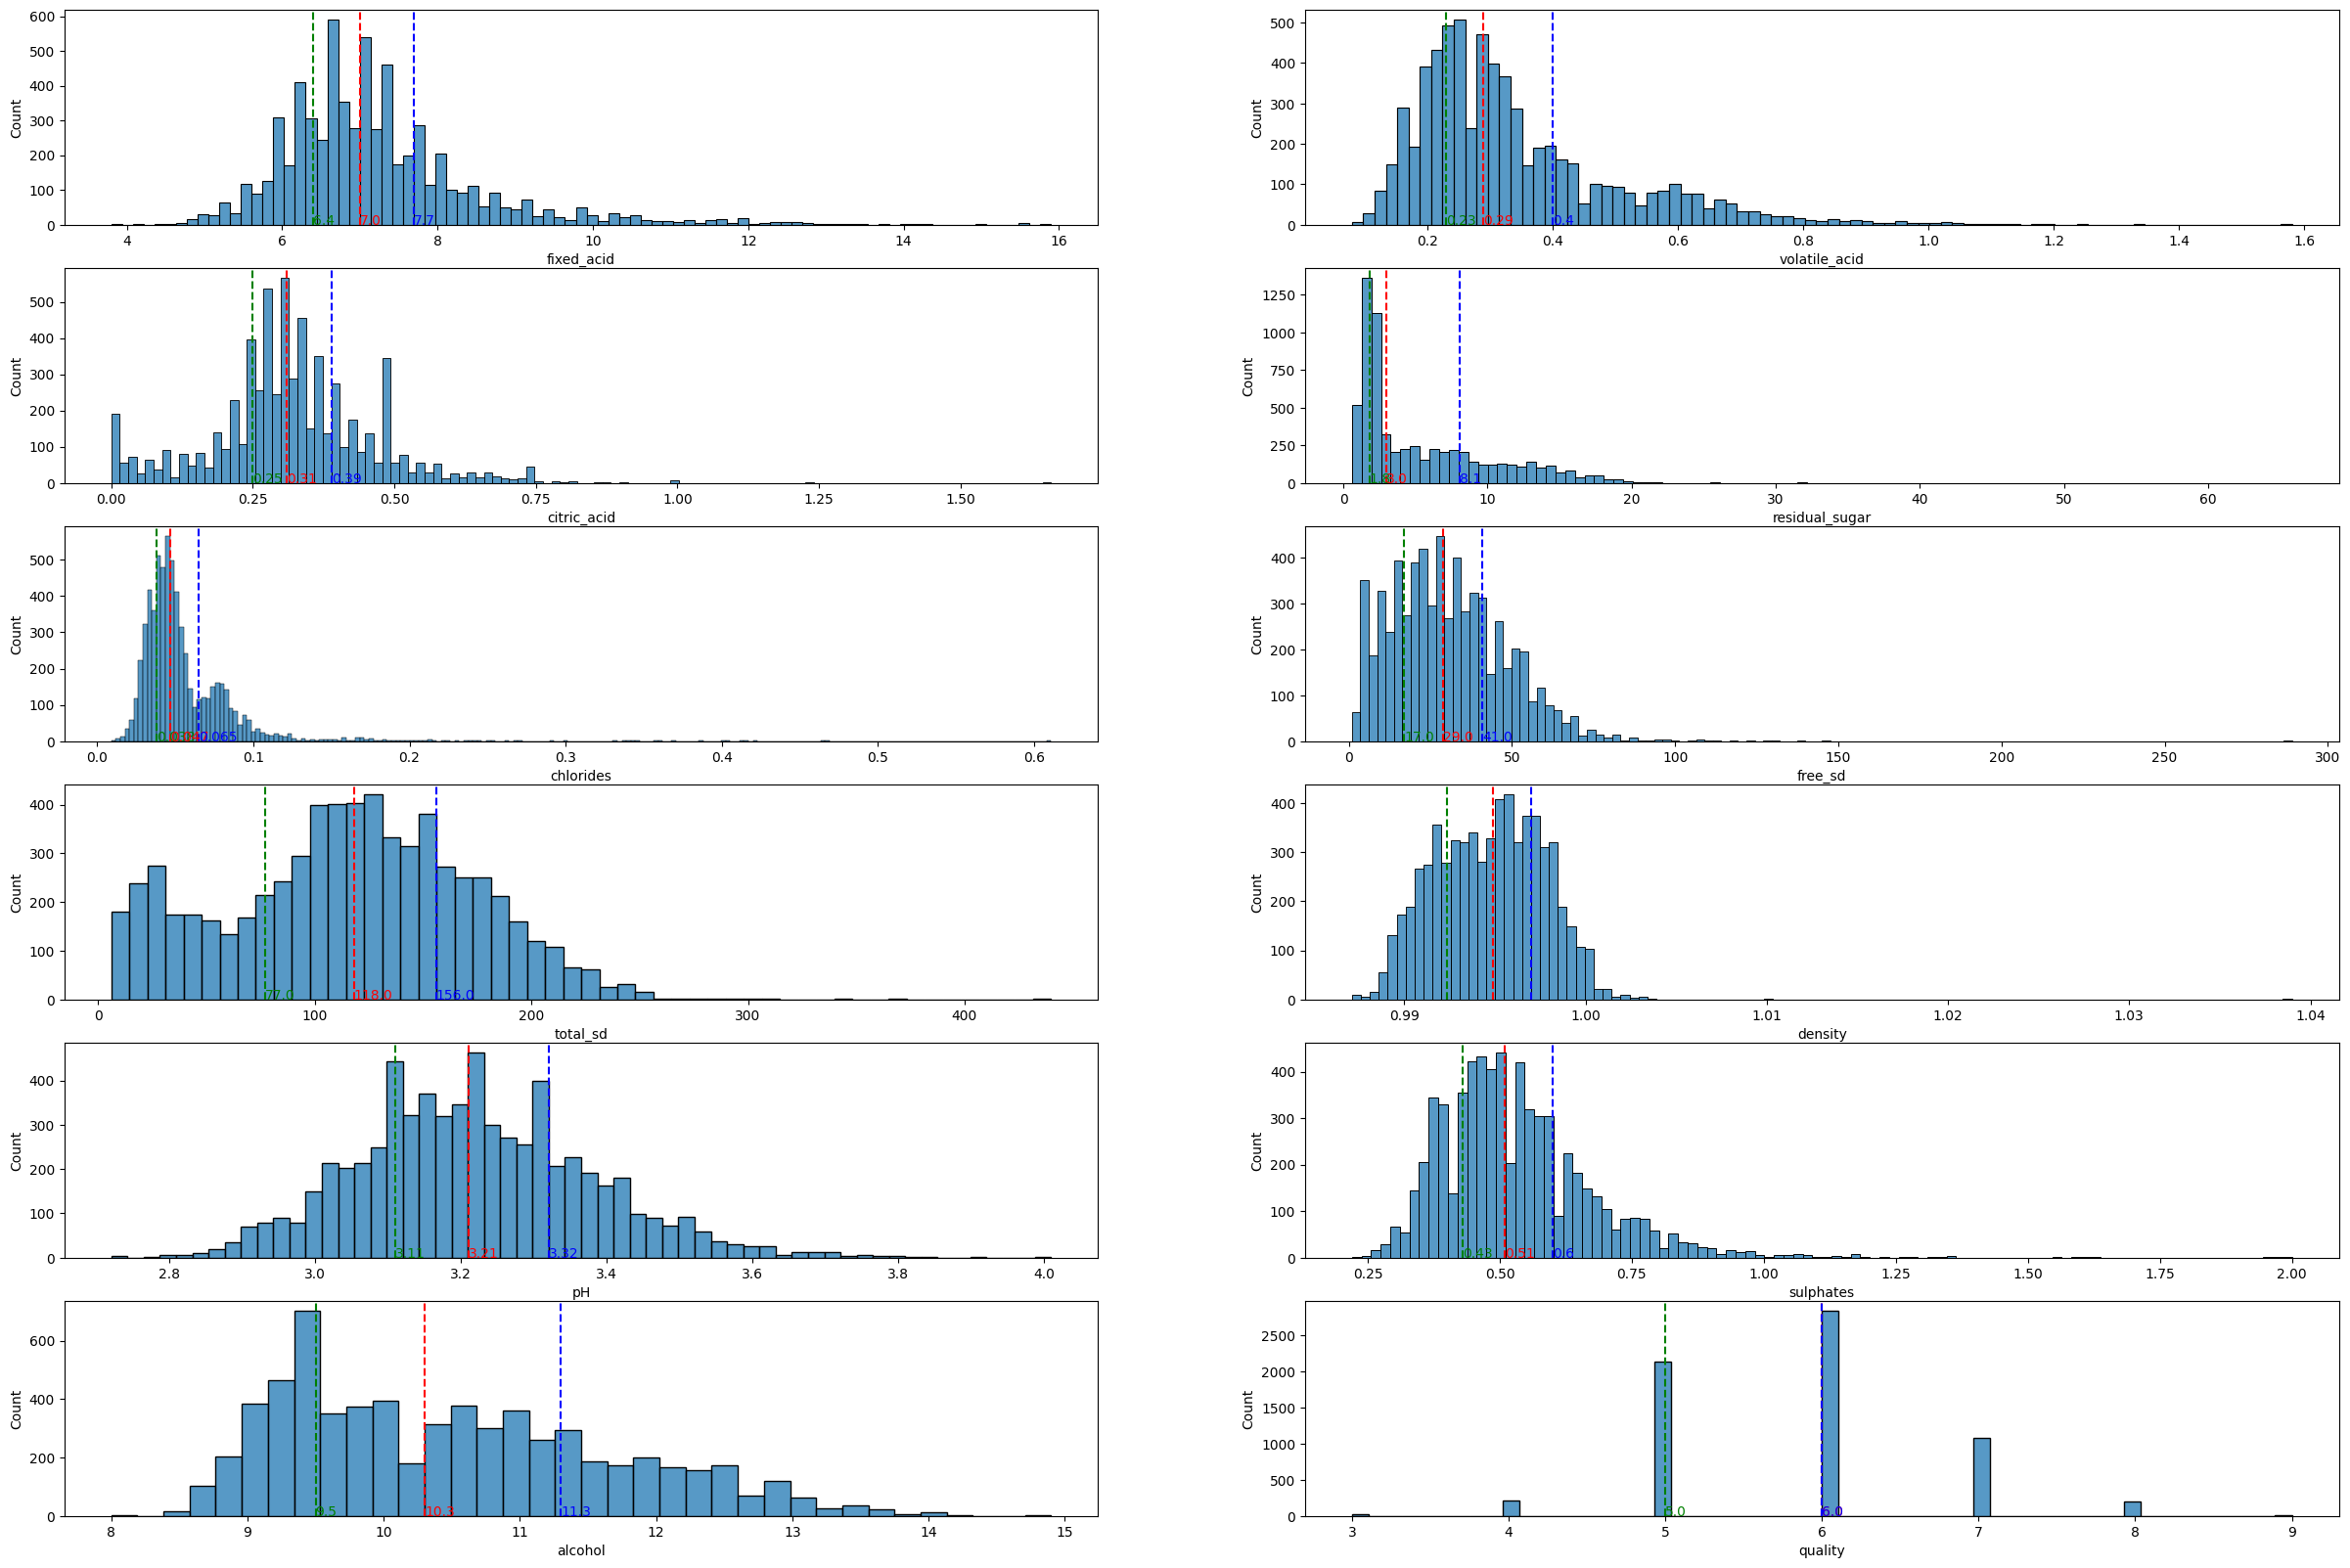

In [6]:
fig, axes = plt.subplots(6, 2, figsize=(30, 20))
quantiles = ['25%','50%', '75%']
colors = ['green', 'red', 'blue']

print_wine = wine_df.drop(columns='type')
for col, ax in zip(print_wine, axes.flat):
#     print(col, ax)
    sns.histplot(ax=ax, data=print_wine, x=print_wine[col], multiple='stack')
    desc = print_wine[col].describe()
#     print(desc)
    for i in range(len(quantiles)):
        ax.axvline(desc[quantiles[i]], color=colors[i], ls='--', label = desc[quantiles[i]])
        ax.annotate(desc[quantiles[i]], (desc[quantiles[i]], -1), color=colors[i])

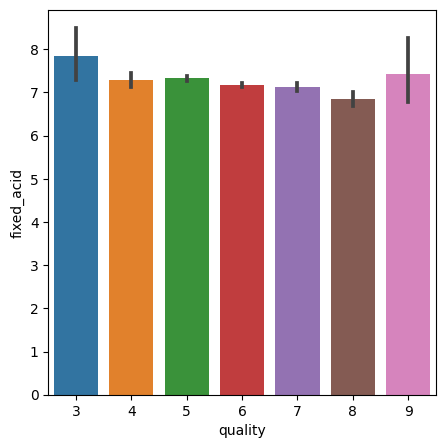

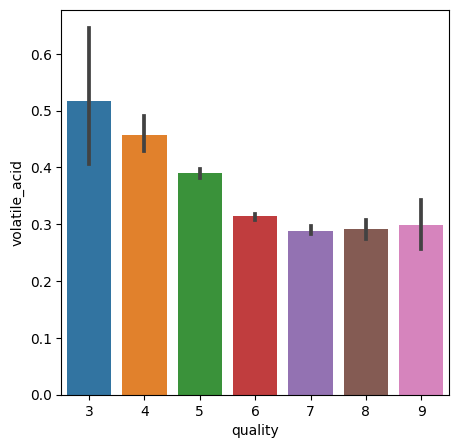

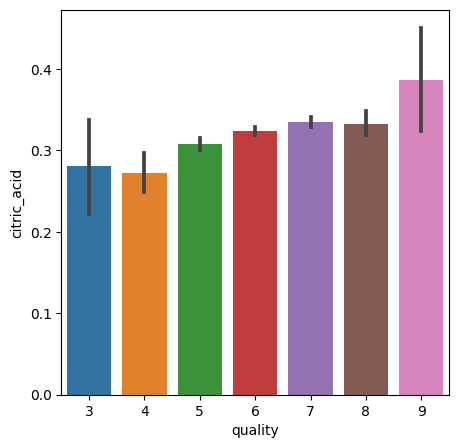

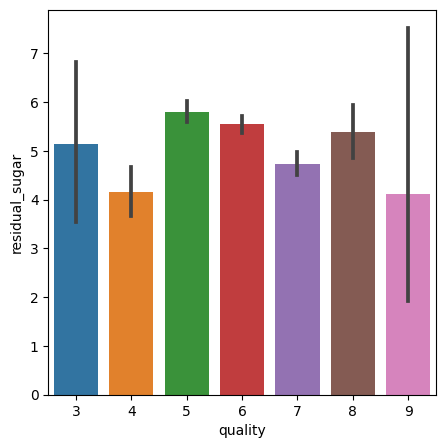

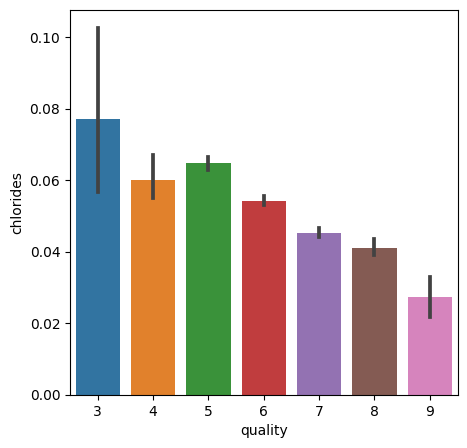

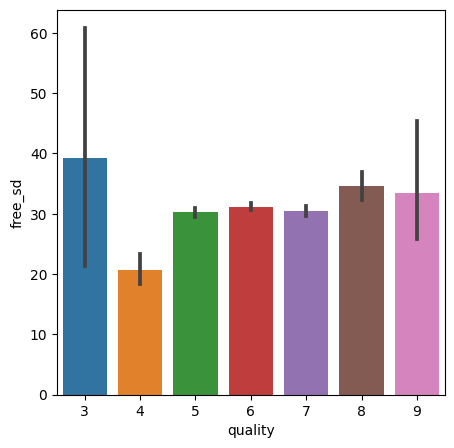

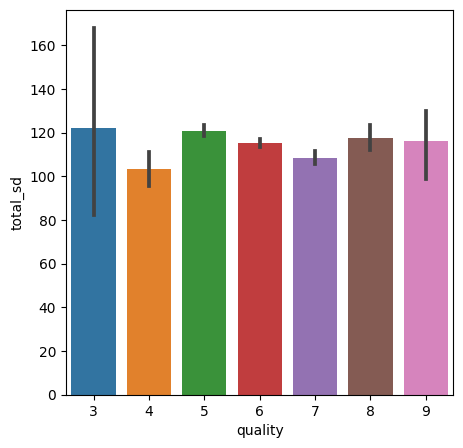

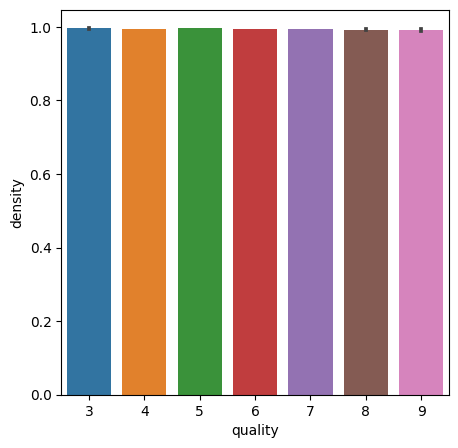

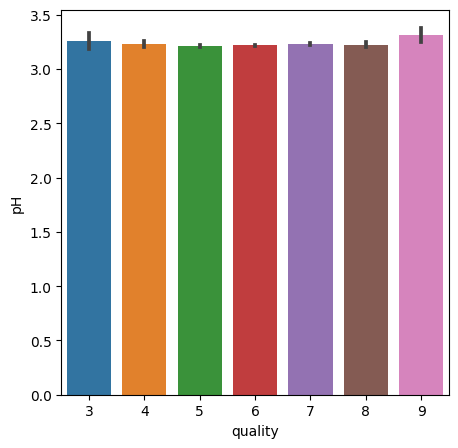

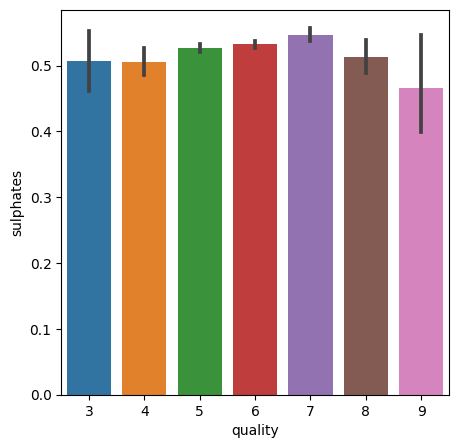

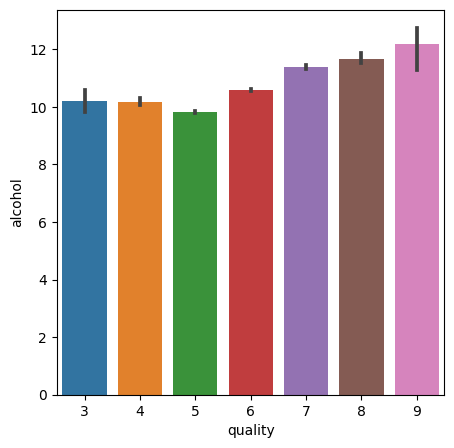

In [7]:
plot_bar_df = wine_df.drop(columns=['quality','type'])
columns = list(plot_bar_df.columns)

for col in range(len(columns)):
  plot = plt.figure(figsize= (5,5))
  sns.barplot(x='quality' , y= columns[col] , data= wine_df)
  plt.xlabel('quality')
  plt.ylabel(columns[col])

  plt.show()

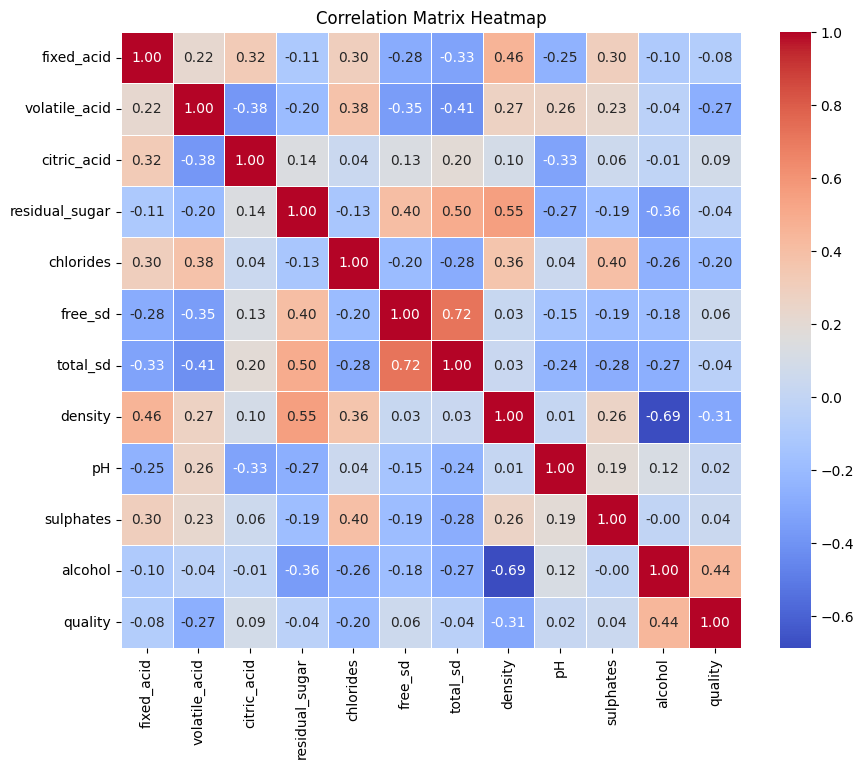

In [8]:
# Drop non-numeric columns
numeric_columns = wine_df.select_dtypes(include='number').columns
numeric_df = wine_df.drop(columns=['type'])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Show the plot
plt.title('Correlation Matrix Heatmap')
plt.show()

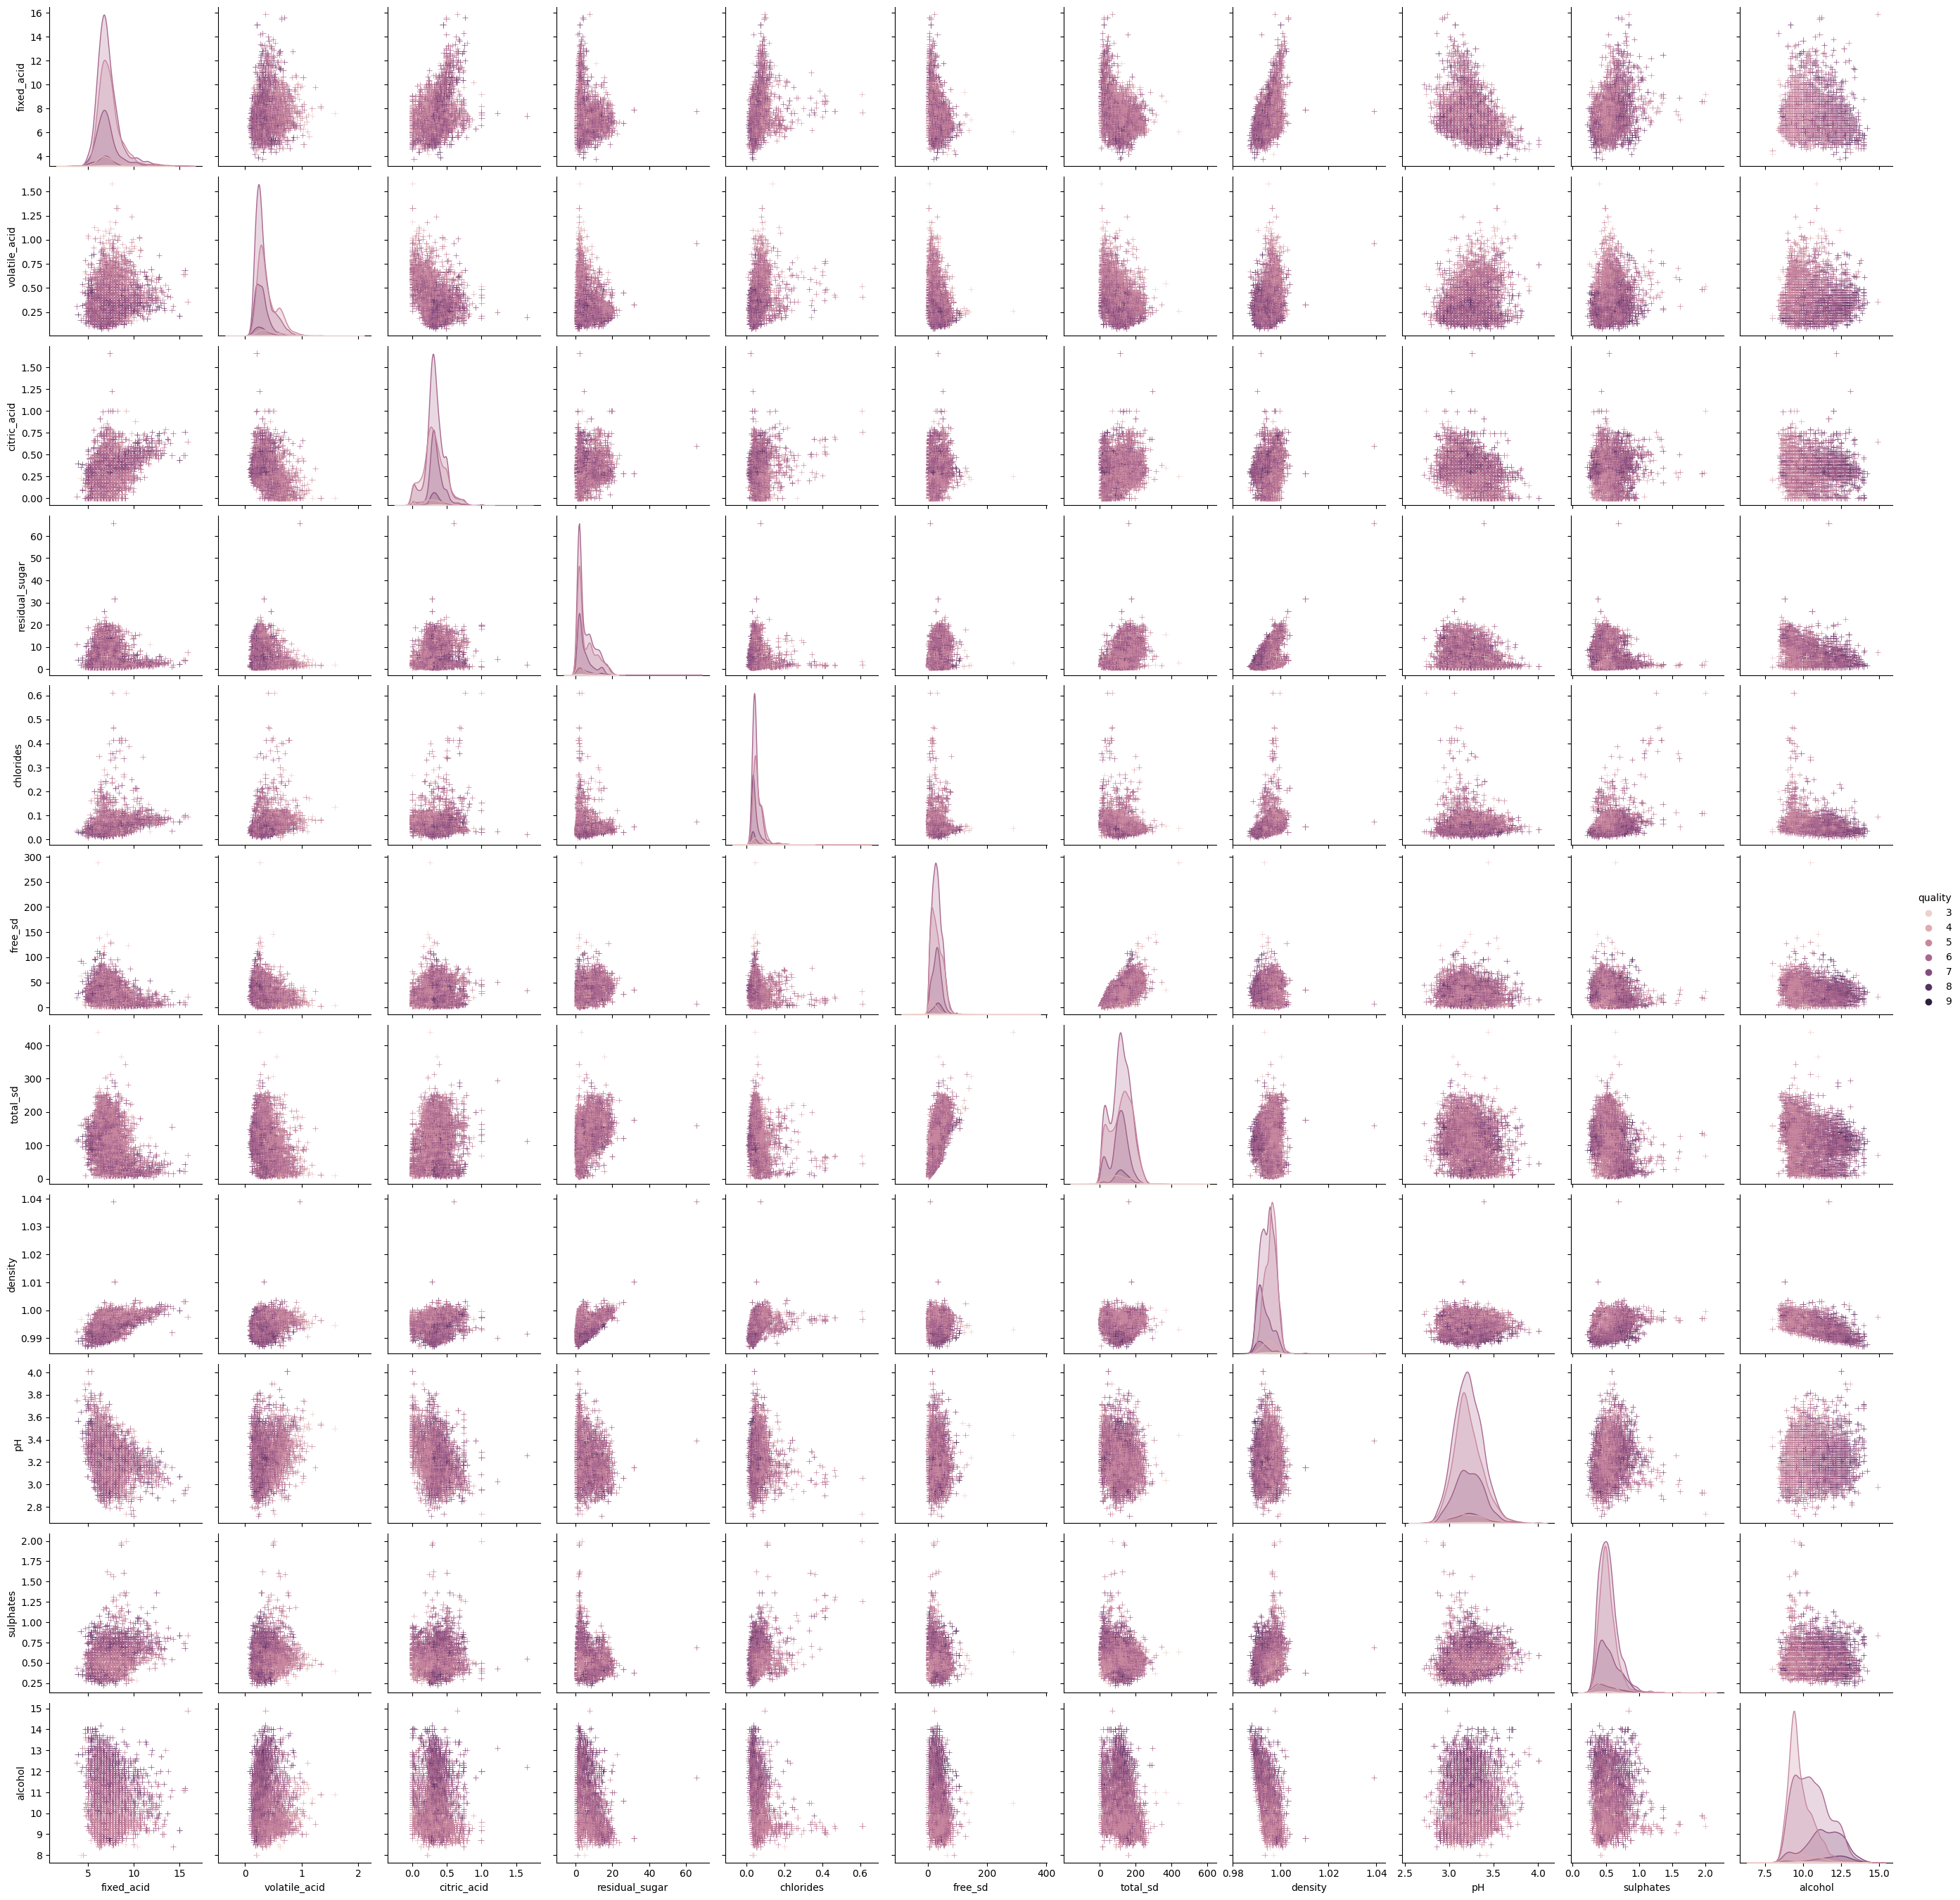

In [9]:
g = sns.pairplot(wine_df, hue='quality', markers='+')
plt.show()

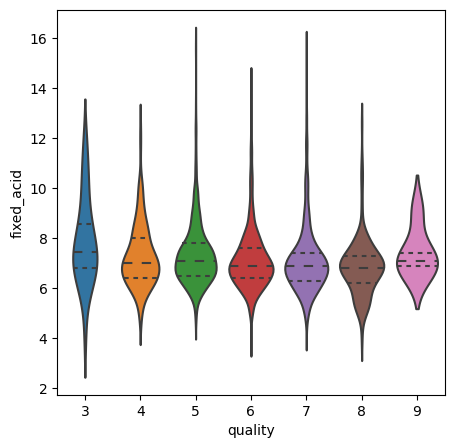

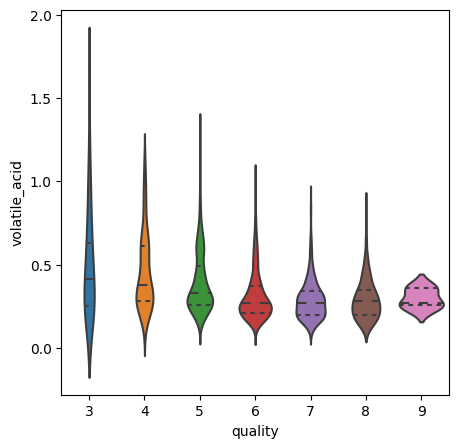

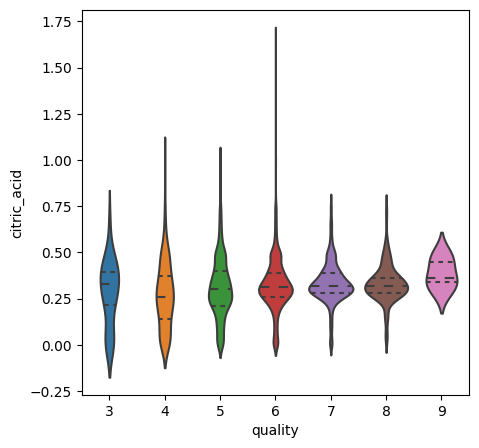

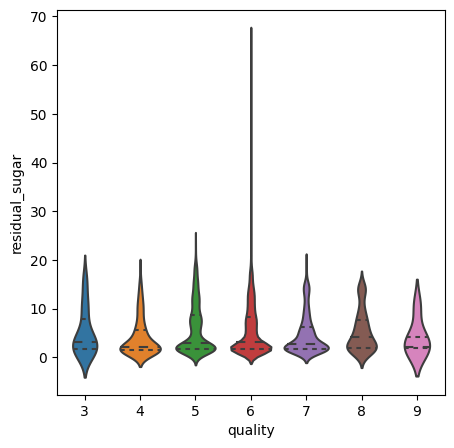

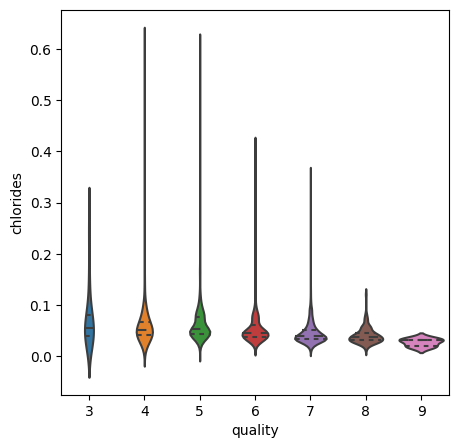

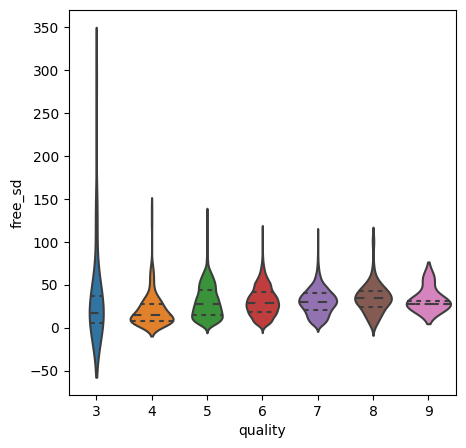

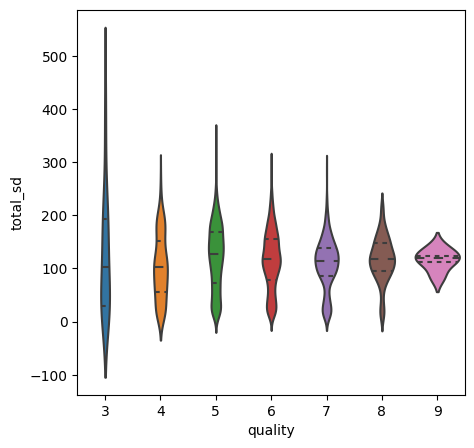

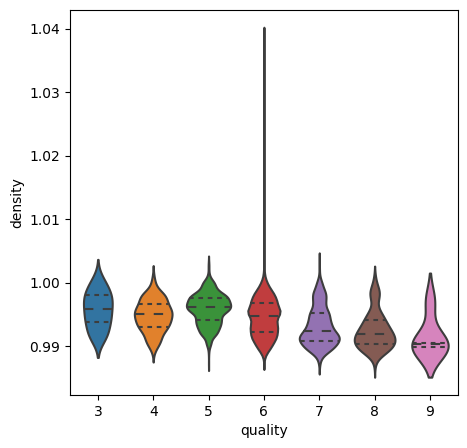

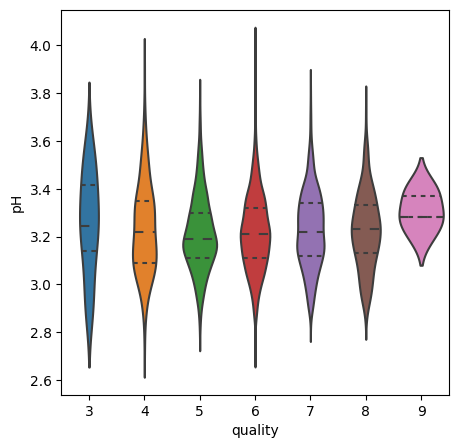

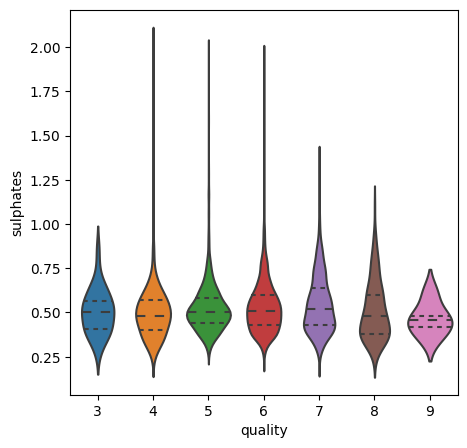

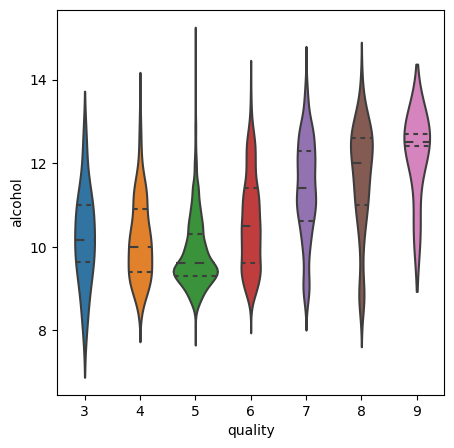

In [10]:
plot_bar_df = wine_df.drop(columns=['quality','type'])
columns = list(plot_bar_df.columns)

for col in range(len(columns)):
  plot = plt.figure(figsize= (5,5))
  g = sns.violinplot(x='quality' , y= columns[col] , data= wine_df, inner='quartile')
  #plt.ylabel('quality')
  #plt.xlabel(columns[col])
  plt.show()

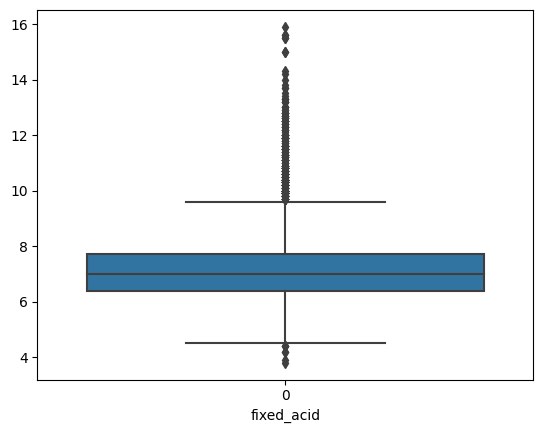

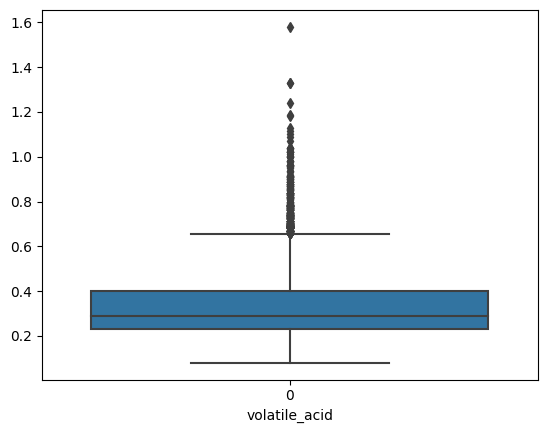

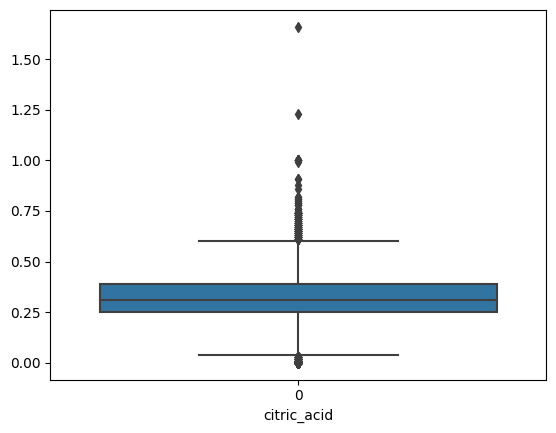

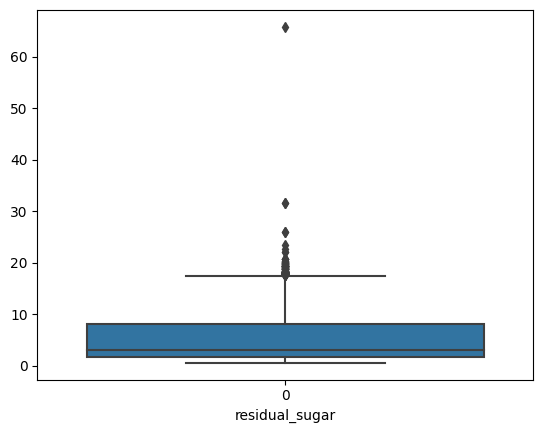

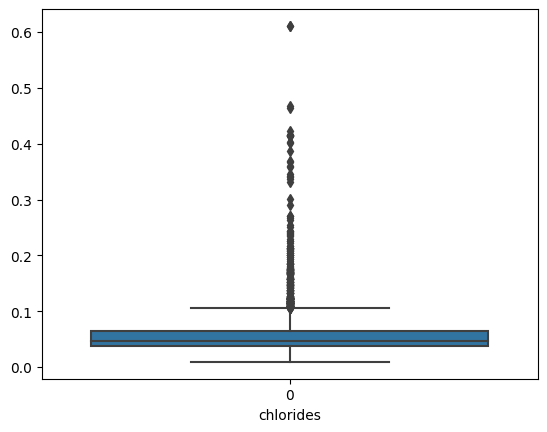

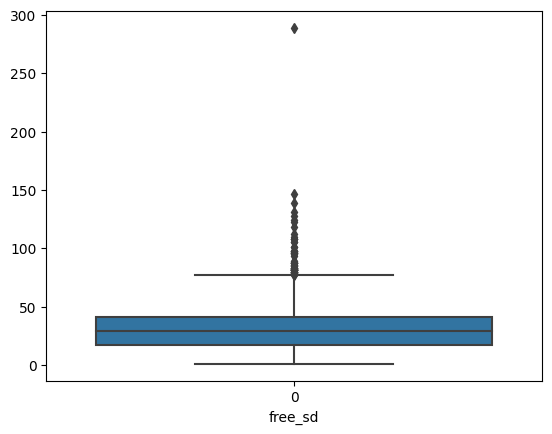

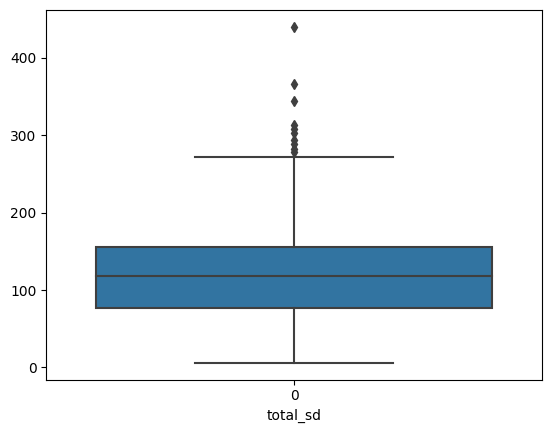

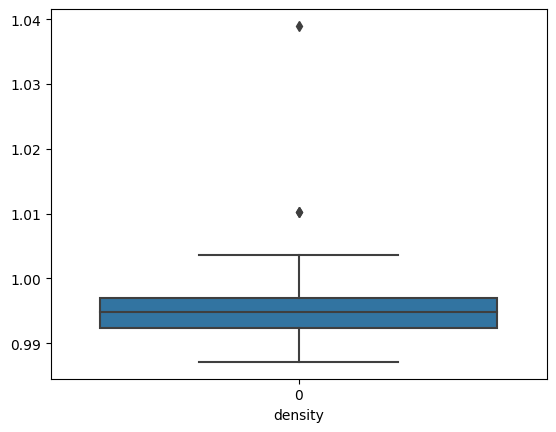

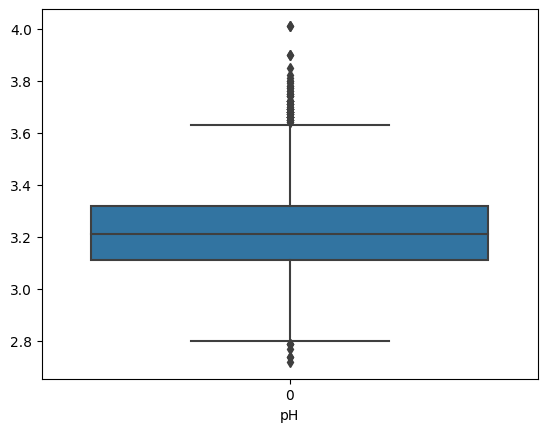

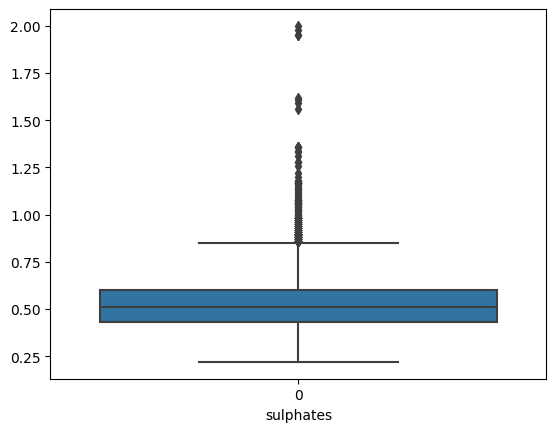

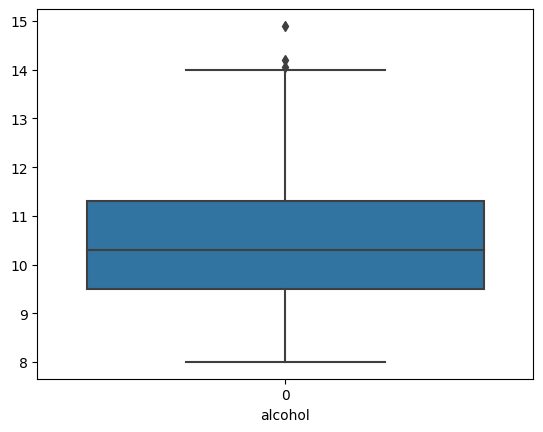

In [11]:
col_list = wine_df.columns

for name in col_list:
  if name != 'type' and name != 'quality':
    sns.boxplot(wine_df[name])
    plt.xlabel(name)
    plt.show()

In [12]:
################ DISTRIBUTION INFO #####################
# - Type can be only: white (75%), red (25%)
# - Density have very low standard deviation (0.3%), possible f-test
# - Chlorides, residal sugar and volatile acid have long tails, with few elements on them
# - Total sulfur dioxide and Free sulfur dioxide are highly correlated and have similar distribution among quality data
# - It's plenty of outliers that could be removed to make the model more stable

In [13]:
################ DATA CLEANING ################
# - Remove the outliners
# - Remove data where there's a missing value and duplicates
# - Remove the variable Total Sulfur Dioxide
# - Make the datatype consistent
# - Variables binning

In [14]:
# Delete the missing values and drop duplicates
clean1_df = wine_df.dropna(axis=0, how="any").drop_duplicates().reset_index(drop=True)
clean1_df = clean1_df.rename_axis("key").reset_index()

# Remove outliners
clean_list = clean1_df.columns
to_remove = set()

for name in clean_list:
  if name != 'type' and name != 'quality' and name != 'key':
    Q1 = clean1_df[name].quantile(0.25)
    Q3 = clean1_df[name].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    # Create arrays of boolean values indicating the outlier rows
    upper_array = np.where(clean1_df[name]>=upper)[0]
    lower_array = np.where(clean1_df[name]<=lower)[0]

    to_remove.update(upper_array)
    to_remove.update(lower_array)

to_remove_list = list(to_remove)
print(to_remove_list)

# Removing the outliers
clean2_df = clean1_df.drop(labels=list(to_remove), axis = 0).drop(columns='key').reset_index(drop=True)
clean2_df = clean2_df.rename_axis("key").reset_index()

clean2_df
clean2_df['fixed_acid'].max()

[0, 4099, 4101, 4102, 2054, 4105, 10, 4107, 2060, 4116, 4117, 4118, 4120, 4124, 4127, 4128, 4129, 4130, 32, 4132, 33, 34, 4135, 2081, 2091, 2044, 4144, 4145, 2101, 4150, 56, 4153, 4154, 2106, 4156, 61, 4158, 4157, 4161, 4163, 4164, 4167, 4168, 4169, 2119, 4171, 2124, 2123, 4174, 4175, 4176, 80, 4178, 4179, 2132, 4181, 4182, 85, 4184, 87, 4186, 4187, 90, 4189, 4190, 4192, 4193, 4194, 4195, 4197, 4198, 4199, 2151, 2152, 4200, 4201, 4204, 4205, 4206, 429, 4208, 113, 4210, 4211, 2161, 4207, 2169, 4219, 4220, 2171, 4223, 4224, 4225, 4226, 4227, 4228, 4229, 2175, 2178, 4233, 138, 4236, 4237, 4238, 4239, 4240, 4241, 4242, 4243, 4244, 2192, 4246, 4247, 4248, 150, 4250, 4245, 4252, 4253, 4254, 4255, 4256, 4257, 161, 4259, 4260, 4261, 4262, 4263, 4264, 166, 4266, 2214, 172, 2217, 4270, 4271, 4272, 4273, 2218, 2219, 4276, 181, 2223, 183, 185, 2234, 4283, 4285, 4286, 4287, 4288, 4289, 4290, 2237, 4292, 4293, 4294, 4296, 4297, 4298, 4299, 2252, 205, 4302, 4303, 204, 4305, 4306, 4308, 4309, 213, 431

9.6